<a href="https://colab.research.google.com/github/JJay1010/K-software_-/blob/main/UnggyuLee/q4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import glob
import json
from PIL import Image
import re
import numpy as np
import tensorflow
import pandas as pd
import os
import tensorflow as tf
import keras
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from datetime import datetime
#rootDir = 'C:/Users/lee/Desktop/swbootcamp/p4/유형별 두피 이미지/Training/'
rootDir = 'E:/q4/유형별 두피 이미지/Training/'

labelDirs = glob.glob(rootDir+'**/*.json',recursive=True)
#imgDirs = glob.glob(rootDir+'**/*.jpg',recursive=True)

imgs =[]
labels = []
width = 60
height =60

In [ ]:


def decodeStatus(encodedStatus):
    
    #권장 라벨
    s0=re.compile('000000') #정상
    s1=re.compile('[123]00000') #건성
    s2=re.compile('0[123]0000') #지성
    s3=re.compile('[0123]0[123]000') #민감성
    s4=re.compile('[0123][123][123]0[0123]0') #지루성
    s5=re.compile('[0123][0123]0[123][0123]0') #염증성
    s6=re.compile('[0123][0123]00[123]0') #비듬성
    s7=re.compile('00000[123]')#탈모성
    
    if(s0.match(encodedStatus)):
        return '정상'
    elif(s1.match(encodedStatus)):
        return '건성'
    elif(s2.match(encodedStatus)):
        return '지성'
    elif(s3.match(encodedStatus)):
        return '민감성'
    elif(s4.match(encodedStatus)):
        return '지루성'
    elif(s5.match(encodedStatus)):
        return '염증성'
    elif(s6.match(encodedStatus)):
        return '비듬성'
    elif(s7.match(encodedStatus)):
        return '탈모성'
    else:
        return '복합성'
def analyze():
    keyList = ['미세각질0','미세각질1','미세각질2','미세각질3',
               '피지과다0','피지과다1','피지과다2','피지과다3',
               '모낭사이홍반0','모낭사이홍반1','모낭사이홍반2','모낭사이홍반3',
               '모낭홍반농포0','모낭홍반농포1','모낭홍반농포2','모낭홍반농포3',
               '비듬0','비듬1','비듬2','비듬3',
               '탈모0','탈모1','탈모2','탈모3']
    valueList = []
    for i in range(len(keyList)):
        valueList.append(0)
    for lDir in labelDirs:
        with open(lDir,'r',encoding='UTF8') as file:
                data = json.load(file)
                counter=0
                for value in data:
                    if(len(data[value])==1):
                        #print(data[value])
                        valueList[4*counter+(int)(data[value])]+=1
                        counter+=1        

    return {x:y for x,y in zip(keyList,valueList)}
                

{'미세각질0': 137571, '미세각질1': 11432, '미세각질2': 13869, '미세각질3': 5555, '피지과다0': 33180, '피지과다1': 67514, '피지과다2': 59037, '피지과다3': 8696, '모낭사이홍반0': 37249, '모낭사이홍반1': 82140, '모낭사이홍반2': 36784, '모낭사이홍반3': 12254, '모낭홍반농포0': 156480, '모낭홍반농포1': 8127, '모낭홍반농포2': 2712, '모낭홍반농포3': 1108, '비듬0': 88232, '비듬1': 47999, '비듬2': 26218, '비듬3': 5978, '탈모0': 114305, '탈모1': 40636, '탈모2': 11165, '탈모3': 2321}


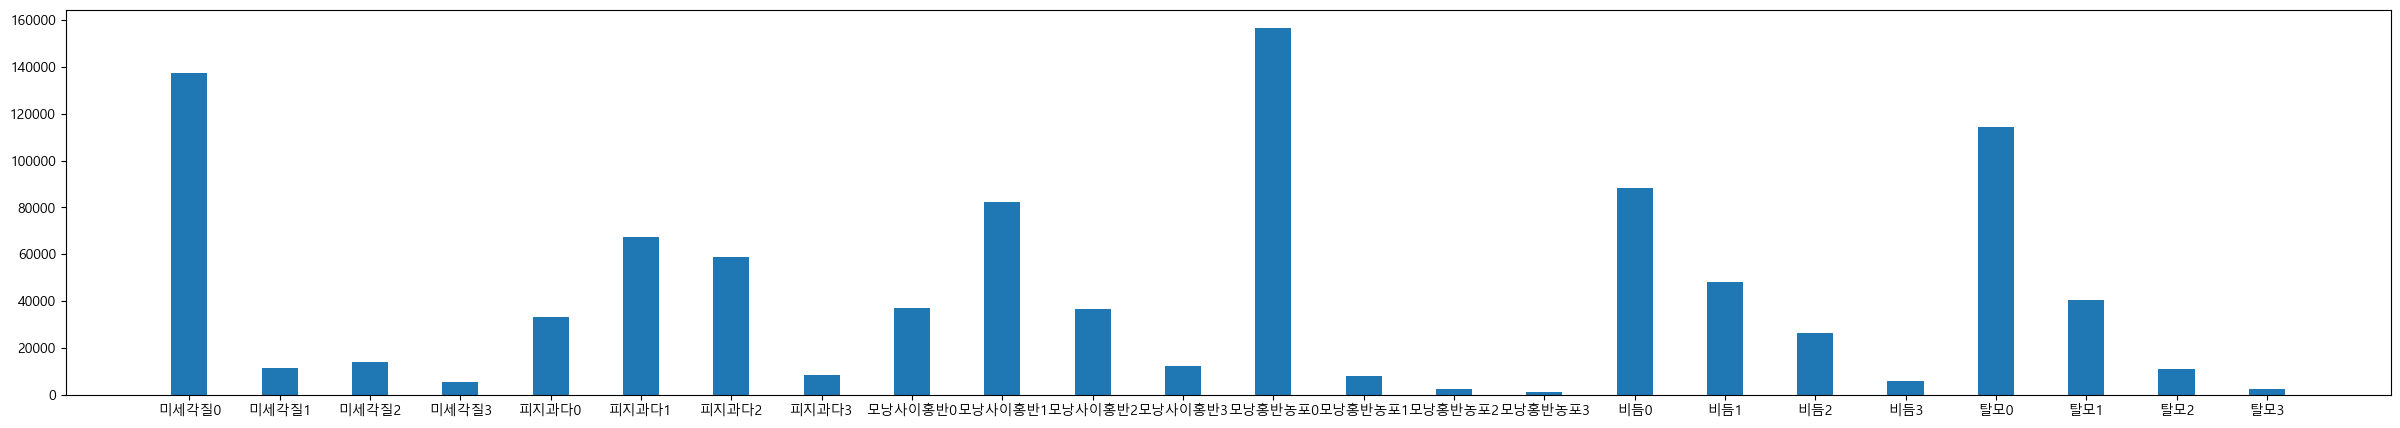

In [ ]:
list_C = analyze()
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(30,5))
plt.bar(range(len(list_C)), list(list_C.values()), align='center',width=0.4)
plt.xticks(range(len(list_C)), list(list_C.keys()))
plt.show()

라벨링 방식
        val1    val2       val3     val4        val5    val6  
순서 : 미세각질,피지과다,모낭사이홍반,모낭홍반/농포,비듬,탈모  
(01) <-상관없음

양호 : 000000                                   ->regex(000000)  
건성 : 100000                                   ->regex(100000)  
지성 : 010000                                   ->regex(010000)  
민감성 : (01)01000                              ->regex([01]01000)  
지루성 : (01)11000                              ->regex([01]11000)  
염증성 : (01)(01)01(01)0                        ->regex([01][01]01[01]0)   
비듬성 : (01)(01)0010                           ->regex([01][01]0010)  
탈모성 : 000001                                 ->regex(000001)

상태값 매핑 : 양호0 건성1 지성2 민감성3 지루성4 염증성5 비듬성6 탈모성7 그외-1

내일할일
json에서 value 1~ value6 값을 읽어서 어떤 상태인지 판단 후 전처리
예) 이미지 1, 양호 와 같은 식으로 이미지와 라벨 매칭


2일차
문제 : 너무 많은 데이터를 메모리에 올릴 수가 없다.  
generator을 쓰면 가능

generator 써도 노트북으로는 너무 많은 시간 소모
데이터셋을 줄일 방법을 생각해본다.  
큰 batch 사이즈와 gpu사용으로 해결

In [ ]:

def genData(label):
    for lDir in labelDirs:
        with open(lDir,'r',encoding='UTF8') as file:
                data = json.load(file)
                new = label.decode('utf-8')      


                label = data[new]
                imgDir = (lDir.replace('라벨','원천')).replace('json','jpg')
                imgData = np.array(Image.open(imgDir).resize((width,height)).convert('RGB'))
                imgData = imgData/255 
               
                label=np.array(label)
                label=keras.utils.to_categorical(label,4)
                label=label.astype(np.int8)
                yield(imgData,label)     

def train(target):
    #모델 빌드
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(width, height, 3)),
        tf.keras.layers.MaxPooling2D((2,2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64,activation='relu'),
        tf.keras.layers.Dense(4,activation='softmax')
    ])
    model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=['accuracy'])
    model.summary()

    dataset = tf.data.Dataset.from_generator(genData,
                                         (tf.int16,4),
                                         ((width,height,3),(4)),
                                         args=(target,))   

    dataset = dataset.shuffle(256).batch(700)
    
    with tf.device("/device:GPU:0"):
        history = model.fit(dataset,epochs=1)
    
    saveDir = 'E:/q4/'+target+'_'+datetime.now().strftime('%Y%m%d_%H%M%S')+'.h5'
    print("save file : "+saveDir)
    model.save(saveDir)

    return history

history = train('value_1')
history2 = train('value_2')
history3= train('value_3')
hitsory4=train('value_4')
history5=train('value_5')
hitsory6=train('value_6')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 7744)              0

학습 정확도 문제  
각종 value를 묶어서 라벨링하면 정확도가 떨어진다  
따라서 각 value별로 모델을 생성(총 6개)해서 판단시키는게 좋아보인다.

모델 검증  

In [ ]:


'''
evalModel

params
modelDir : directory of model
labelNum : target label
'''
def evalModel(modelDir,labelNum):
    loadedModel = tf.keras.models.load_model(modelDir)
    vRootDir = 'E:/q4/유형별 두피 이미지/Validation/'

    vDirs = glob.glob(vRootDir+'**/*.json',recursive=True)
    imgs =[]
    labels = []
    length = len(vDirs)
    counter = 0

    vDataSet = tf.data.Dataset.from_generator(genData,
                                         (tf.int16,4),
                                         ((width,height,3),(4)),
                                         args=(labelNum,))   
    vDataSet = vDataSet.batch(700)                                     
    print('evaluate start')
    score = loadedModel.evaluate(vDataSet)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

def gendataV(label,vDirs):
    for lDir in vDirs:
        with open(lDir,'r',encoding='UTF8') as file:
                data = json.load(file)
                new = label.decode('utf-8')      


                label = data[new]
                imgDir = (lDir.replace('라벨','원천')).replace('json','jpg')
                imgData = np.array(Image.open(imgDir).resize((width,height)).convert('RGB'))
                imgData = imgData/255 
               
                label=np.array(label)
                label=keras.utils.to_categorical(label,4)
                label=label.astype(np.int8)
                yield(imgData,label)     

#input your own model directory
evalModel('value_1_20230120_021349.h5','value_1')
evalModel('value_2_20230120_030048.h5','value_2')
evalModel('value_3_20230120_034818.h5','value_3')
evalModel('value_4_20230120_043444.h5','value_4')
evalModel('value_5_20230120_052115.h5','value_5')
evalModel('value_6_20230120_060706.h5','value_6')











In [ ]:
#from IPython.display import Image

def result(modelDirs, imgDir):
    list = []
    imgData = Image.open(imgDir)
    imgData
    imgData= np.array(Image.open(imgDir).resize((width,height)).convert('RGB'))
    imgData=imgData/255
    imgData= imgData.reshape(-1,width,height,3)
    

    for i in modelDirs:
        loadedModel = tf.keras.models.load_model(i)
        list.append(loadedModel.predict(imgData,).argmax())
        
        
    print("result : " ,list)
    return list

#your own models
modelDirList = ['value_1_20230120_021349.h5',
                'value_2_20230120_030048.h5',
                'value_3_20230120_034818.h5',
                'value_4_20230120_043444.h5',
                'value_5_20230120_052115.h5',
                'value_6_20230120_060706.h5']
#target Img
imgDir = 'E:/q4/img1.jpg'
result(modelDirList,imgDir)








    

1/1 [==============================] - 0s 59ms/step
result :  [0, 2, 0, 0, 0, 0]


[0, 2, 0, 0, 0, 0]